In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from diffusers import DDPMPipeline, DDIMScheduler
from datasets import load_dataset
import matplotlib.pyplot as plt

device = (
    'mps' if torch.backends.mps.is_available()  # MPS: Multi-Process Service,目前只支持Linux
    else 'cuda' if torch.cuda.is_available()
    else 'cpu'
)
print(f'Using device: {device}')

Using device: cuda


In [3]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.22.0.dev0",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

  0%|          | 0/1000 [00:00<?, ?it/s]

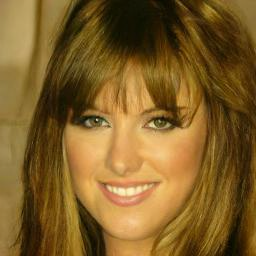

In [ ]:
# RTX4060 wall time: 29m 13.4s
mages = image_pipe().images
images[0]


In [5]:
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

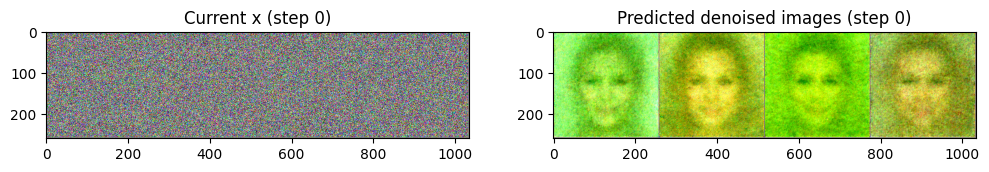

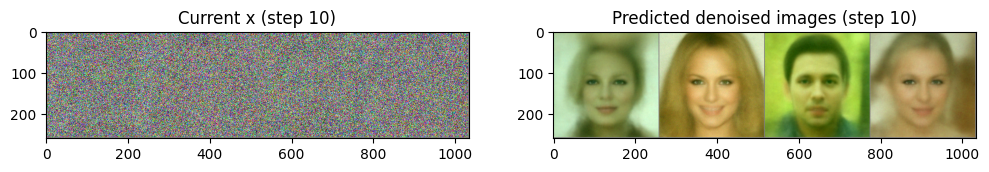

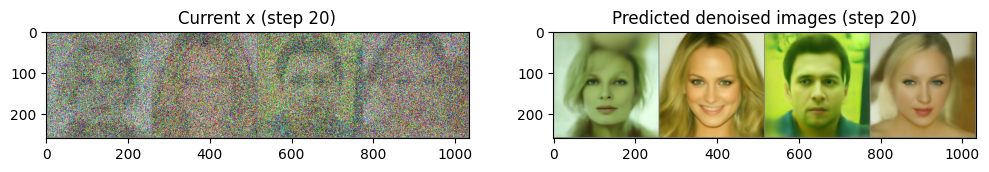

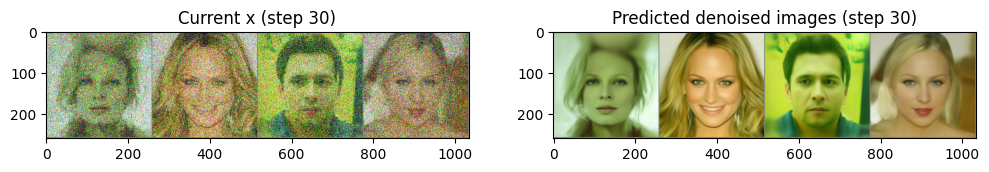

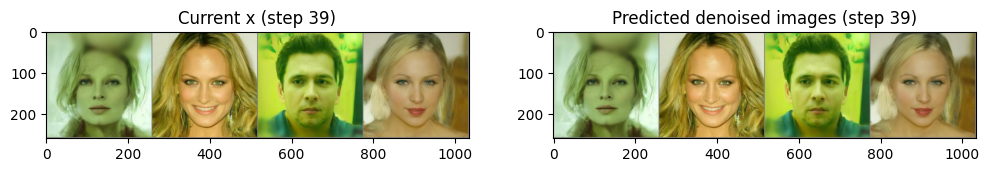

In [4]:
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps)):
    
    model_input = scheduler.scale_model_input(x, t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # 使用调度器计算更新后的样本应该是什么样子
    scheduler_output = scheduler.step(noise_pred, t, x)

    # 更新输入图像
    x = scheduler_output.prev_sample

    
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample

        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()



  0%|          | 0/40 [00:00<?, ?it/s]

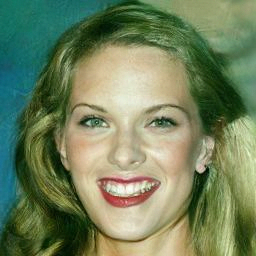

In [6]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

In [7]:
dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name, split="train")
print(dataset)
image_size = 256
batch_size = 4
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)


Repo card metadata block was not found. Setting CardData to empty.


Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})


Previewing batch:


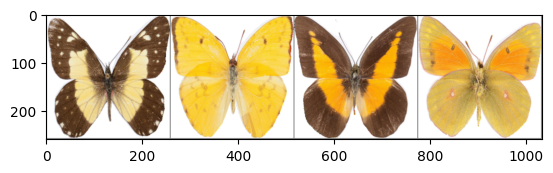

In [8]:
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)


  0%|          | 0/250 [00:00<?, ?it/s]

c:\Users\83633\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.014463413052260876


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.011726610743324272


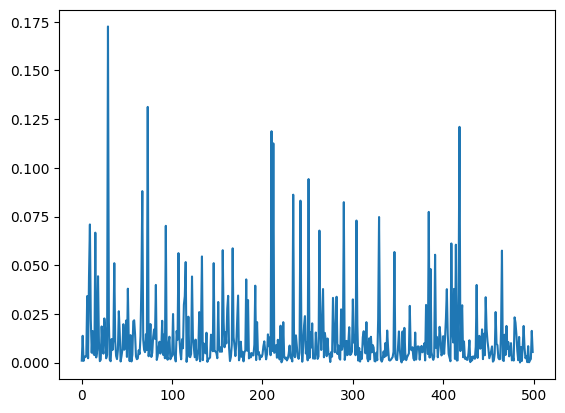

In [9]:
num_epochs = 2
lr = 1e-5
grad_accumulation_steps = 2

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)
losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader),
                            total=len(train_dataloader)):
        clean_images = batch["images"].to(device)

        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        timesteps = torch.randint(
            0,
            image_pipe.scheduler.config.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        loss = F.mse_loss(noise_pred, noise)

        losses.append(loss.item())

        loss.backward()

        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
        )
    
plt.plot(losses)


0it [00:00, ?it/s]

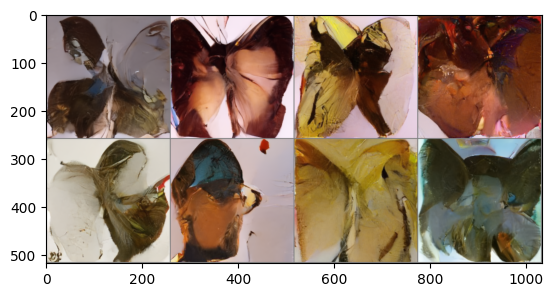

In [12]:
x = torch.randn(8, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

In [ ]:
image_pipe.save_pretrained("my-finetuned-model")


In [ ]:
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

model_name = "ddpm-celebahq-finetuned-butterflies-2epochs"

local_folder_name = "my-finetuned-model"

description = "Describe your model here"
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(
    folder_path=f"{local_folder_name}/scheduler",
    path_in_repo="",
    repo_id=hub_model_id,
)
api.upload_folder(
    folder_path=f"{local_folder_name}/unet",
    path_in_repo="",
    repo_id=hub_model_id,
)
api.upload_file(
    path_or_fileobj=f"{local_folder_name}/model_index.json",
    path_in_repo="model_index.json",
    repo_id=hub_model_id,
)

# 创建模型卡片
from huggingface_hub import ModelCard

content = f"""
---
license: mit
tags:
- pytorch
- diffusers
- unconditional-image-generation
- diffusion-models-class
---
# 这个模型是用来生成蝴蝶图片的无条件图像生成扩散模型

```python
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained("{hub_model_id}")
image = pipeline().images[0]
image
"""

card = ModelCard(content)
card.push_to_hub(hub_model_id)

In [ ]:
!wget https://github.com/huggingface/diffusion-models-class/raw/main/unit2/finetune_model.py

In [ ]:
# 8G显存是运行不了的，需要更大的显存
!bash finetune_model.sh